In [1]:
pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.2
    Uninstalling nbformat-5.9.2:
      Successfully uninstalled nb

In [2]:
pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 3.5 MB/s eta 0:00:00


In [3]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 999.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=ccdb8bdbccf16d4a03633fabc0f57b9fec543a057cac642f10933949471d5eb7
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=141a252c1e463c88a963f25fb4911830e99e8014dc616cacf41939ea295bee3e
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 106.5 MB/s eta 0:00:00


In [4]:
!unzip cow_mesh.zip

Archive:  cow_mesh.zip
   creating: cow_mesh/
  inflating: __MACOSX/._cow_mesh     
  inflating: cow_mesh/cow_texture.png  
  inflating: __MACOSX/cow_mesh/._cow_texture.png  
  inflating: cow_mesh/cow.obj        
  inflating: __MACOSX/cow_mesh/._cow.obj  
  inflating: cow_mesh/cow.mtl        
  inflating: __MACOSX/cow_mesh/._cow.mtl  


In [5]:
#!/usr/bin/env python3
import numpy as np
import open3d
import os
import sys
import torch
import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes,load_obj
from pytorch3d.vis.plotly_vis import get_camera_wireframe
# Data structures and functions for rendering
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PerspectiveCameras,
    PointLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer
)

In [6]:

from pytorch3d.renderer.mesh.shader import HardPhongShader

In [7]:
# Définir les chemins

obj_filename = "cow_mesh/cow.obj"
device = torch.device('cuda')


In [43]:
# Charger le fichier obj
mesh = load_objs_as_meshes([obj_filename], device=device)

In [44]:
# Nous normalisons l'échelle et centrons le maillage cible pour qu'il tienne dans une sphère de rayon 1, centrée sur (0,0,0).
# centré sur (0,0,0). (scale, center) sera utilisé pour ramener le maillage prédit
# à son centre et à son échelle d'origine.  Notez que la normalisation du maillage cible,
# accélère l'optimisation mais n'est pas nécessaire !
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-(center.expand(N, 3)))
mesh.scale_verts_((1.0 / float(scale)))

In [10]:
verts.shape

torch.Size([2930, 3])

In [11]:
verts,faces = mesh.verts_packed().cpu().numpy(),mesh.faces_packed().cpu().numpy()
np.min(verts,0),np.max(verts,0)

(array([-0.54687625, -0.97388893, -0.99999994], dtype=float32),
 array([0.54687625, 0.98656505, 0.9923225 ], dtype=float32))

In [45]:
R, T = look_at_view_transform(2.7, 0,180) # 10 45 90 180 270
cameras = PerspectiveCameras(device=device, R=R, T=T)

In [46]:
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)


In [47]:
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader = HardPhongShader(
        device = device,
        cameras = cameras,
        lights = lights
    )
)

(-0.5, 511.5, 511.5, -0.5)

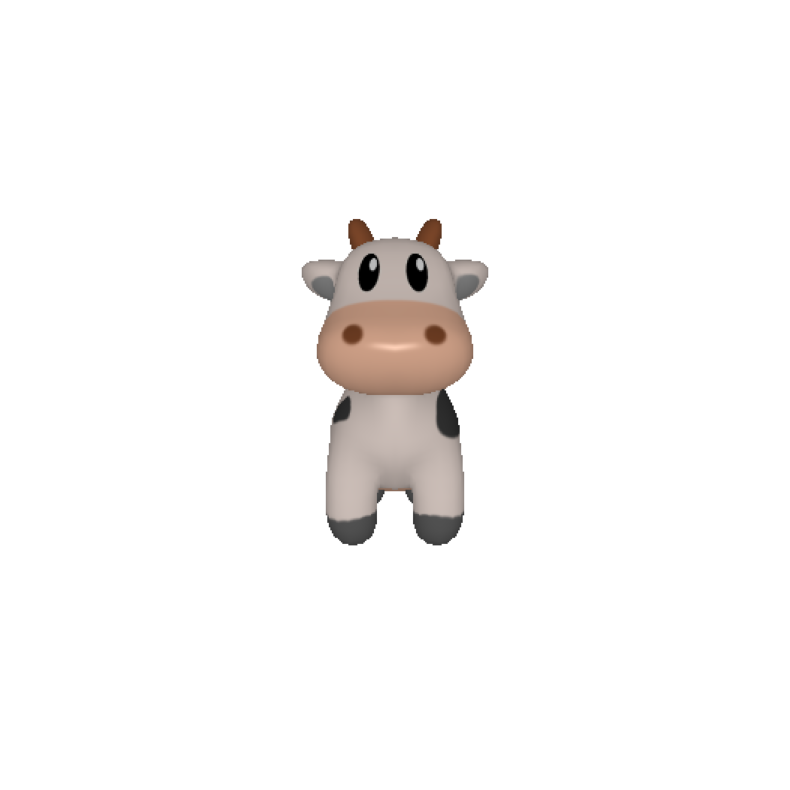

In [48]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
#plt.savefig('light_at_front.png')


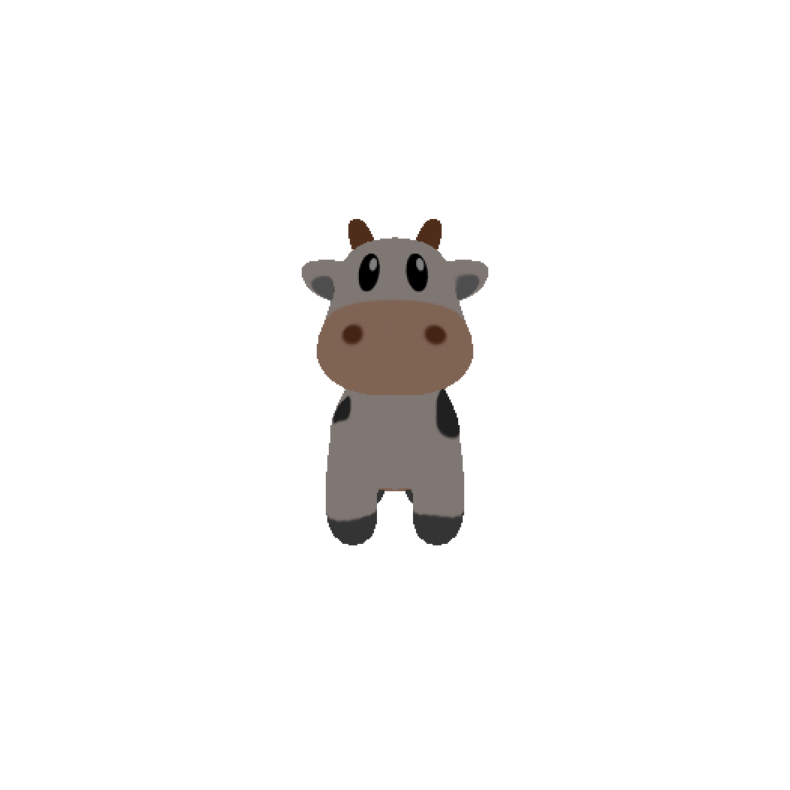

In [49]:
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights, )

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");
#plt.savefig('light_at_back.png')

Ici, nous modifions la configuration de manière à ce que les composantes ambiantes soient proches de 0 (en fait, de 0,01). Comme la source de lumière ponctuelle se trouve derrière l'objet et que la lumière ambiante est également désactivée, l'objet rendu ne reflète plus aucune lumière. L'objet rendu ne reflète plus aucune lumière.

(-0.5, 511.5, 511.5, -0.5)

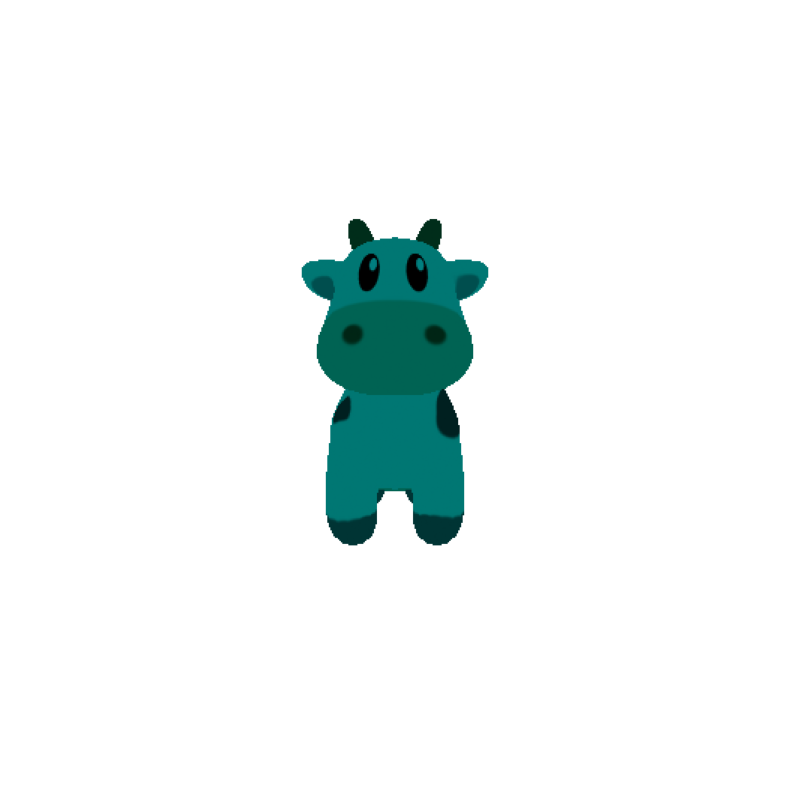

In [56]:

lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
materials = Materials(
    device=device,
    ambient_color=((0, 1, 1),),
)
images = renderer(mesh, lights=lights, materials = materials)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
#plt.savefig('dark.png')


Dans la prochaine expérience, nous ferons à nouveau pivoter la caméra et redéfinirons l'emplacement de la source de lumière de manière à ce que la lumière puisse éclairer le visage de la vache. Notez que lorsque nous définissons le matériau, nous fixons la brillance à 10,0. Ce paramètre de brillance est précisément le paramètre p du modèle d'éclairage Phong. specular_color est [0.0, 1.0, 0.0], ce qui implique que la surface est brillante principalement dans la composante verte.

(-0.5, 511.5, 511.5, -0.5)

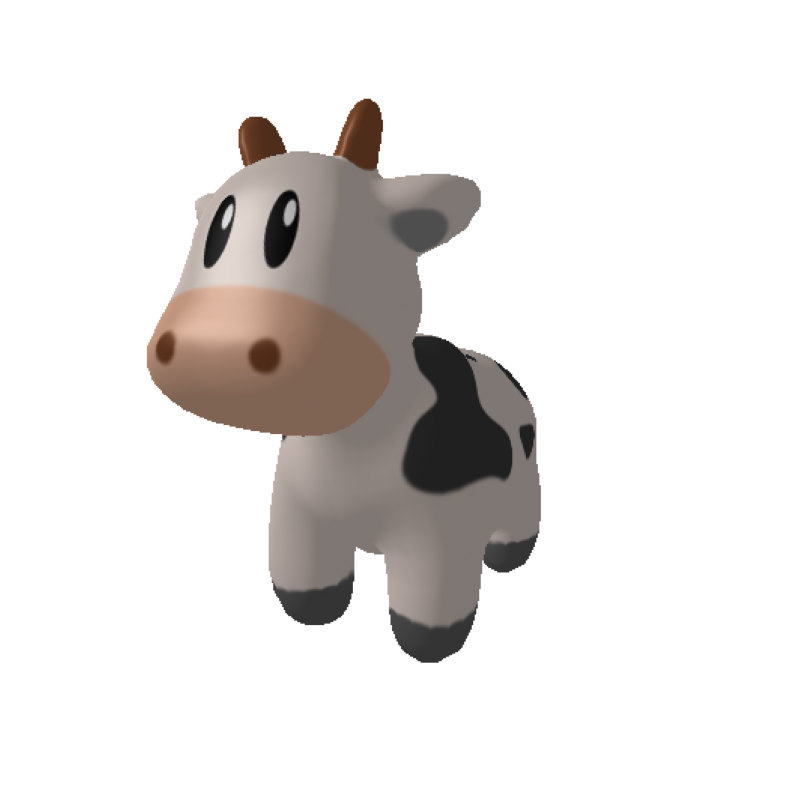

In [61]:

R, T = look_at_view_transform(dist=2.7, elev=10, azim=-150)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

materials = Materials(
    device=device,
    specular_color=[[1.0, 1.0, 1.0]],
    shininess=20
)

images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
#plt.savefig('green.png')